In [1]:
!pip install tensorflow keras opencv-python-headless matplotlib scikit-learn


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from PIL import ImageFile

# Allow loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [3]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sinhadhossainfahim","key":"ea2928cdeb741c32e28cc5d08a3128ba"}'}

In [4]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d bmadushanirodrigo/fracture-multi-region-x-ray-data
!unzip fracture-multi-region-x-ray-data.zip

Streaming output truncated to the last 5000 lines.
  inflating: Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/14-rotated2-rotated2-rotated3 (1).jpg  
  inflating: Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/14-rotated2-rotated2-rotated3-rotated1 (1).jpg  
  inflating: Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/14-rotated2-rotated2-rotated3-rotated1.jpg  
  inflating: Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/14-rotated2-rotated2-rotated3.jpg  
  inflating: Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/14-rotated2-rotated2.jpg  
  inflating: Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/14-rotated2-rotated3 (1).jpg  
  inflating: Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Enhanced Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup data generators with class balancing
class_weights = {
    0: 1.,  # weight for 'fractured'
    1: (337 / 492)  # weight for 'not fractured' to balance the dataset
}

train_generator = train_datagen.flow_from_directory(
    '/content/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train',
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_directory(
    '/content/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val',
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 9246 images belonging to 2 classes.
Found 829 images belonging to 2 classes.


In [9]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

# Unfreeze the top layers of the base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [10]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    class_weight=class_weights
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8457 - loss: 0.2595

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


288/288 ━━━━━━━━━━━━━━━━━━━━ 507s 1s/step - accuracy: 0.8460 - loss: 0.2591 - val_accuracy: 0.5462 - val_loss: 0.6862
Epoch 2/20
  1/288 ━━━━━━━━━━━━━━━━━━━━ 2:06 442ms/step - accuracy: 1.0000 - loss: 0.0028

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


288/288 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 0.2759 - val_loss: 0.7550
Epoch 3/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 254s 868ms/step - accuracy: 0.9851 - loss: 0.0342 - val_accuracy: 0.8438 - val_loss: 0.3367
Epoch 4/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 455us/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 0.1850
Epoch 5/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 251s 855ms/step - accuracy: 0.9942 - loss: 0.0181 - val_accuracy: 0.9538 - val_loss: 0.1021
Epoch 6/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 449us/step - accuracy: 0.9688 - loss: 0.1238 - val_accuracy: 1.0000 - val_loss: 0.0848
Epoch 7/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 251s 858ms/step - accuracy: 0.9954 - loss: 0.0129 - val_accuracy: 0.9825 - val_loss: 0.0403
Epoch 8/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 451us/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 1.0000 - val_loss: 0.1336
Epoch 9/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 250s 852ms/step - accuracy: 0.9980 - loss: 0.0066 - val

26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 285ms/step - accuracy: 0.9859 - loss: 0.0474
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 605ms/step


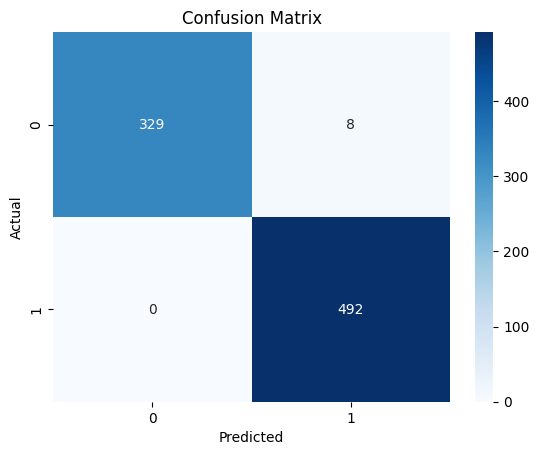

               precision    recall  f1-score   support

    fractured       1.00      0.98      0.99       337
not fractured       0.98      1.00      0.99       492

     accuracy                           0.99       829
    macro avg       0.99      0.99      0.99       829
 weighted avg       0.99      0.99      0.99       829



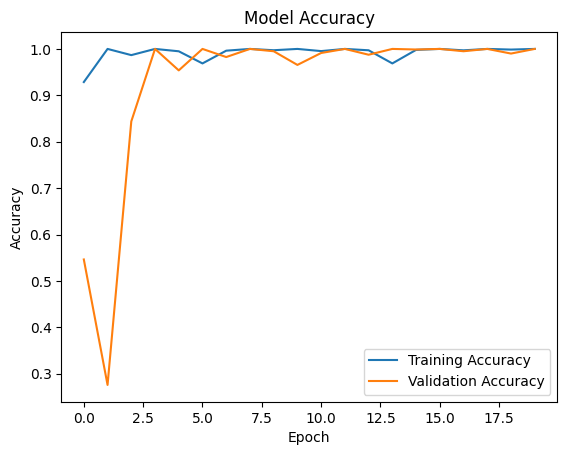

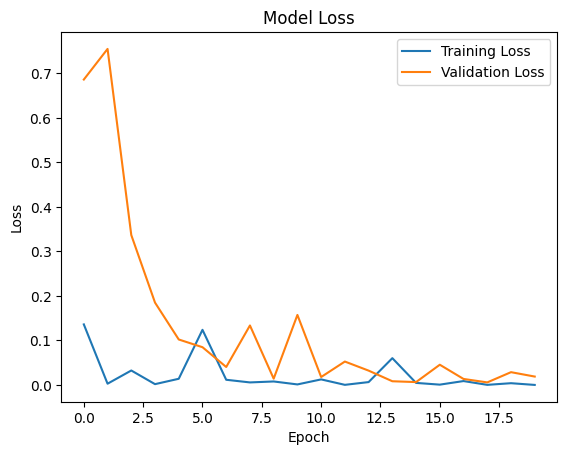

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Evaluate the model
val_loss, val_accuracy = model.evaluate(valid_generator)
predictions = (model.predict(valid_generator) > 0.5).astype(int)
true_labels = valid_generator.classes

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print(classification_report(true_labels, predictions, target_names=['fractured', 'not fractured']))

# Plot Accuracy and Loss
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [12]:
test_generator = valid_datagen.flow_from_directory(
    '/content/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test',
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Found 506 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 1.0000 - loss: 0.0021
Test Loss: 0.002106833504512906
Test Accuracy: 1.0


16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 587ms/step


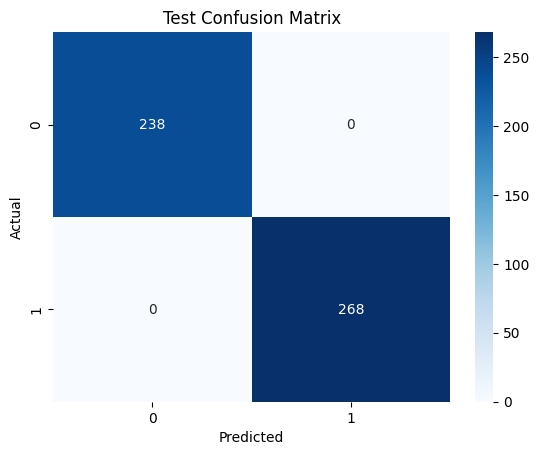

In [13]:
test_predictions = (model.predict(test_generator) > 0.5).astype(int)
test_true_labels = test_generator.classes

# Confusion Matrix
test_conf_matrix = confusion_matrix(test_true_labels, test_predictions)
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [14]:
# Example list of image paths - replace with actual paths to your images
test_images = ['/content/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/fractured/000151.png', '/content/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured/0047.png']

# Verify paths
print(test_images)


['/content/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/fractured/000151.png', '/content/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured/0047.png']


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


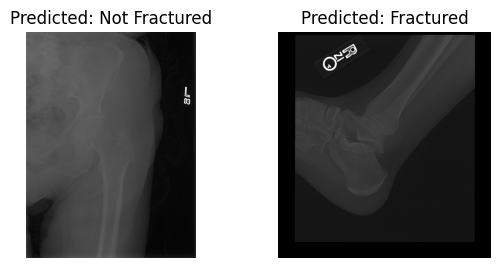

In [15]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

def load_and_predict(img_path, model):
    img = image.load_img(img_path, target_size=(300, 300))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    return prediction

# Assuming you have verified that `test_images` contains correct paths:
plt.figure(figsize=(10, 10))
for i, img_path in enumerate(test_images):
    prediction = load_and_predict(img_path, model)
    pred_label = 'Fractured' if prediction[0] > 0.5 else 'Not Fractured'
    plt.subplot(3, 3, i + 1)
    plt.imshow(image.load_img(img_path))
    plt.title(f'Predicted: {pred_label}')
    plt.axis('off')
plt.show()
